Agentic RAG : An advance version of RAG where instead of static, one shot LLM response, the system uses an agent that : 
- Reasons
- Plans
- Retrieves
- Uses Tools
- and even retries or reflects to generate better, more grounded answers.

In [1]:
import os
from typing import List, Annotated
from typing_extensions import TypedDict

from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_anthropic import ChatAnthropic
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
from langchain_core.documents import Document



/Users/akashdeepsangwan/Desktop/Code/GenAI/AgenticAI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()



True

In [3]:
# Chat
api_key = os.getenv("claudeAPI")

claude = ChatAnthropic(
    model = "claude-haiku-4-5-20251001",
    temperature = 0.7,
    api_key = api_key
)


In [9]:
# Document Processing

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]

loaders = [WebBaseLoader(url) for url in urls]
docs = []


for loader in loaders:
    docs.extend(loader.load())


In [ ]:
## Create the chunks 
from langchain_huggingface import HuggingFaceEmbeddings

splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500, 
    chunk_overlap = 50
)

split_docs = splitter.split_documents(docs) # Split_documents take array as input

Embeddings = HuggingFaceEmbeddings(
    model_name  = "sentence-transformers/all-MiniLM-L6-v2"
)

vectorstore = FAISS.from_documents(split_docs, Embeddings)
retriever = vectorstore.as_retriever()

In [35]:
retriever.invoke("what is an agent")

[Document(id='ff43cde9-304d-4396-bba5-3f6ae8a4c06c', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [71]:
from typing import TypedDict

class RAGState(TypedDict):
    question: str
    retrieved_docs: List[Document]
    answer: str



In [72]:
# Retriever Node
# With TypedDict, state is accessed as a dictionary

def retriever_docs(state: RAGState) -> dict:
    # Access state as dictionary (TypedDict)
    docs = retriever.invoke(state["question"])
    return {
        "question": state["question"],
        "retrieved_docs": docs,
        "answer": ""
    }


def generate_answer(state: RAGState) -> dict:
    # Access state as dictionary (TypedDict)
    context = "\n\n".join([doc.page_content for doc in state["retrieved_docs"]])
    prompt = f"Answer the question based on the context. \n\n Context : {context} \n\n Question : {state['question']}"
    response = claude.invoke(prompt)
    return {
        "question": state["question"],
        "retrieved_docs": state["retrieved_docs"],
        "answer": response.content
    }
        

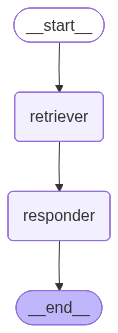

In [73]:
# Graph 

builder = StateGraph(RAGState)
builder.add_node("retriever", retriever_docs)
builder.add_node("responder", generate_answer)

builder.set_entry_point("retriever") # we didn't use Start Here
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph


In [74]:

user_question = "what is the concept of agent loop in autonomous agent" 
# Create initial state as dictionary (TypedDict)
initial_state: RAGState = {
    "question": user_question,
    "retrieved_docs": [],
    "answer": ""
}
final_state = graph.invoke(initial_state)
print(final_state['answer'])



# The Concept of Agent Loop in Autonomous Agents

Based on the context provided, the **agent loop** in autonomous agents refers to the iterative cycle through which an LLM-powered agent operates as its core controller. Here are the key aspects:

## Core Components of the Agent Loop:

1. **Planning & Decision Making**
   - The agent creates plans to optimize believability and effectiveness over time
   - Plans are structured in broad strokes (e.g., daily task breakdowns)

2. **Observation & Relationship Awareness**
   - The agent considers relationships between multiple agents
   - It observes and processes information from other agents
   - Environment information is structured in a tree format for processing

3. **Action Execution**
   - The agent takes actions based on its plans and observations

4. **Self-Reflection & Learning**
   - The agent reflects on past actions and outcomes
   - It refines decisions and corrects mistakes
   - Learning history is concatenated and fed back into